# Transformée en Ondelettes 2D, application au traitement des images

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
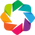

In [1]:
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
import pywt
import scipy.io as sio
import pandas as pd
import holoviews as hv
import param
import panel as pn
from panel.pane import LaTeX
hv.extension('bokeh')
from PIL import Image
from io import BytesIO
import requests
import boto3
import os

In [2]:
s3_endpoint_url = 'https://object-rook-ceph.apps.math.cnrs.fr/'
s3_access_key_id = '9F7EB8YBUWXDV7A4IZYW' # le contenu de secrets/dossal
s3_secret_access_key = 'skV01Eei5M3xVOxROIDr3qymYhWtkrxPpMyj8nwb' # le contenu de secrets/dossal
s3_bucket = 'signal-image'
s3 = boto3.client('s3',
                  '',
                  endpoint_url = s3_endpoint_url,
                  aws_access_key_id = s3_access_key_id,
                  aws_secret_access_key = s3_secret_access_key)
Data=["Lenna.jpg","Canaletto.jpeg","MinotaureBruite.jpeg","Cartoon.jpg"]
if not os.path.isfile('Lenna.jpg'):
    for filenames in Data:  
        s3.download_file(s3_bucket,filenames,filenames)
def chargeData(name):
    if name=='Lenna':
        res=np.array(Image.open("Lenna.jpg")).astype(float)
    if name=='Canaletto':
        res=np.array(Image.open("Canaletto.jpeg")).astype(float)
    if name=='Minotaure':
        res=np.array(Image.open("MinotaureBruite.jpeg")).astype(float)  
    if name=='Cartoon':
        res=np.array(Image.open("Cartoon.jpg")).astype(float) 
    return res
options1=dict(width=400,height=400,xaxis=None,yaxis=None,toolbar=None)
options2=dict(width=700,height=400,xaxis=None,yaxis=None,toolbar=None)

## Approximation linéaire et non linéaire.

In [3]:
im2=chargeData('Lenna')
im=chargeData('Canaletto')
imagesRef= {"Lenna" : im2,"Canaletto" : im}
options = dict(cmap='gray',xaxis=None,yaxis=None,width=400,height=400,toolbar=None)
#pn.Row(hv.Raster(imagesRef["Lenna"]).opts(**options),hv.Raster(imagesRef["Canaletto"]).opts(**options))

In [4]:
size=400
WT= pywt.wavedecn(im, 'haar', mode='per', level=2)
arr, coeff_slices = pywt.coeffs_to_array(WT)
#hv.Image(arr).opts(cmap='gray',width=size,height=size)

Ecrire une fonction qui réalise une approxiamtion non linéaire en seuillant les coefficients d'ondelettes.
On pourra utiliser les fonctions suivante : pywt.coeffs_to_array et pywt.array_to_coeffs

In [5]:
def ApproxOnd2D(S,qmf,L,threshold):
    WTB= pywt.wavedecn(S, qmf, mode='per', level=L)
    arr, coeff_slices = pywt.coeffs_to_array(WTB)
    WTS=arr*(np.abs(arr)>threshold)
    ncoeffs = pywt.array_to_coeffs(WTS, coeff_slices)
    Srec=pywt.waverecn(ncoeffs,qmf,mode='per')
    return Srec,ncoeffs


Ecrire une focntion PSNR.

In [6]:
def PSNR(I,Iref):
    mse = np.mean( (Iref - I) ** 2 )
    if mse == 0:
        return 100
    Val_MAX = np.max(Iref)
    return 20 * np.log10(Val_MAX / np.sqrt(mse))

Ecrire une fonction qui réalise une approximation non linéaire en conservant un nombre N de coefficients d'ondelettes et la tester. On pourra utiliser les fonctions pywt.ravel_coeffs et unravel_coeffs.

In [7]:
def ApproxOnd2nonlin(I,qmf,L,N):
    # Calculate dimensions
    rows, cols = I.shape
    N1 = rows*cols
    
    # Maximum level of decomposition
    Lmax = pywt.dwtn_max_level((rows,cols), pywt.Wavelet(qmf))
    L1 = min(L, Lmax)

    # 2D Wavelet decomposition
    WT = pywt.wavedec2(I, qmf, mode='per', level=L1)
    arr, coeff_slices, shapes = pywt.ravel_coeffs(WT)

    # Sort coefficients
    Ind = np.argsort(np.abs(arr))

    # Retain N largest coefficients
    WTS = np.zeros(N1)
    WTS[Ind[int(N1-N):int(N1)]] = arr[Ind[int(N1-N):int(N1)]]

    # Reconstruct signal
    coeffs_from_arr = pywt.unravel_coeffs(WTS, coeff_slices,shapes)
    Irec = pywt.waverecn(coeffs_from_arr, qmf, mode='per')
    
    p = PSNR(I, Irec)
    return Irec, p

Créer un Dashboard qui permet d'explorer la fonction précédente.

In [8]:
wavelist = ['haar','db2','db3','db4','coif1','coif2','coif3']

In [9]:
class Approx2D(param.Parameterized):
    image = param.ObjectSelector(default="Canaletto",objects=imagesRef.keys())
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    L = param.Integer(5,bounds=(0,10))
    N = param.Integer(2000,bounds=(1,10000))
  #  @param.depends('wave', 'N', 'L')
    def view(self):
        Irec, p = ApproxOnd2nonlin(imagesRef[self.image],self.wave,self.L,self.N)
        return pn.Column(hv.Image(Irec).opts(cmap='gray',width=400,height=400))

In [10]:
approx2D = Approx2D()
#pn.Row(approx2D.param,approx2D.view)

Créer un plan d'experiences qui permet d'explorer la fonction ApproxOnd2nonlin

In [11]:
import itertools
wavelist = ['haar','db2','db3','db4','coif1','coif2','coif3']
experiences = {'Image':imagesRef,'N':np.linspace(1000,50000,30),'wave':wavelist}
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())),columns=experiences.keys())

In [12]:
print(dfexp["Image"][0])

Lenna


Créer la fonction qui à une ligne de la base de donnée précédente calcule le PSNR associé.

In [13]:
def row2PSNR(row):
    L=5
    I,p=ApproxOnd2nonlin(imagesRef[row.Image], row['wave'], L, row['N'])
    return {'PSNR':p}

Appliquer la fonction sur la base de donnée et ajouter la colonne PSNR à la base de données dfexp 

In [14]:
# print(dfexp.iloc[1]['wave'])

result2 = dfexp.apply(row2PSNR, axis=1)
print(result2)

0      {'PSNR': 23.563183899352474}
1       {'PSNR': 25.39677999872454}
2      {'PSNR': 26.083401142201176}
3       {'PSNR': 25.17257079203985}
4      {'PSNR': 25.815702320692292}
                   ...             
415     {'PSNR': 38.54599561888402}
416     {'PSNR': 38.82266174892224}
417     {'PSNR': 38.24845512429929}
418    {'PSNR': 38.959013616178744}
419     {'PSNR': 39.26981011134211}
Length: 420, dtype: object


In [15]:
dfexp['PSNR'] = pd.DataFrame.from_records(result2)['PSNR']

In [16]:
print(dfexp)

         Image        N   wave       PSNR
0        Lenna   1000.0   haar  23.563184
1        Lenna   1000.0    db2  25.396780
2        Lenna   1000.0    db3  26.083401
3        Lenna   1000.0    db4  25.172571
4        Lenna   1000.0  coif1  25.815702
..         ...      ...    ...        ...
415  Canaletto  50000.0    db3  38.545996
416  Canaletto  50000.0    db4  38.822662
417  Canaletto  50000.0  coif1  38.248455
418  Canaletto  50000.0  coif2  38.959014
419  Canaletto  50000.0  coif3  39.269810

[420 rows x 4 columns]


Utiliser hvplot pour visualiser la base de données.

In [17]:
import hvplot.pandas

In [18]:
from bokeh.models import HoverTool
h = HoverTool()
dfexp.hvplot('N','PSNR',by='wave',kind='scatter',groupby=['Image'])\
.opts(width=600,tools = [h]).redim.range(PSNR=(20,70),translation=(-0.5,10.5))

:DynamicMap   [Image]
   :NdOverlay   [wave]
      :Scatter   [N]   (PSNR)

In [19]:
#print(dfexp)


## Débruitage d'images

Ecrire une fonction qui effectue un seuillage dur en ondelettes et la tester. On pourra utiliser la fonction pywt.ravel_coeffs et on pensera à cliper le résultat entre 0 et 255.

In [20]:
def SeuillageDurOndelettes(I,qmf,L,Seuil):
        WTB= pywt.wavedecn(I, qmf, mode='per', level=L)
        coeff_arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(WTB)
        WTS=coeff_arr*(np.abs(coeff_arr)>Seuil)
        coeffs_from_arr = pywt.unravel_coeffs(WTS, coeff_slices,coeff_shapes)
        Irec=pywt.waverecn(coeffs_from_arr,qmf,mode='per')
        Irec=np.clip(Irec,0,255)
        return Irec

Construire un dashboard qui permet d'explorer la fonction SeuillageDurOndelettes.

In [21]:
class WaveSeuillage(param.Parameterized):
    image = param.ObjectSelector(default="Canaletto",objects=imagesRef.keys())
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    L = param.Integer(7,bounds=(0,7))
    Seuil = param.Number(10,bounds=(1,1000))
    def view(self):
        Irec = SeuillageDurOndelettes(imagesRef[self.image],self.wave,self.L,self.Seuil)
        return pn.Column(hv.Image(Irec).opts(cmap='gray',width=400,height=400))

In [22]:
waveseuil = WaveSeuillage()
#pn.Row(waveseuil.param,waveseuil.view)

In [23]:
n1,n2=np.shape(im)
B=np.random.randn(n1,n2)
sigma=10
ib=im+sigma*B
ib=np.clip(ib,0,255)
#hv.Image(ib).opts(cmap='gray',width=400,height=400)


Ecrire un dashboard qui permet de visualiser rapidement l'effet d'un débruitage en ondelettes et qui renvoie les images originales, bruitées et débruitées ainsi que les PSNR associés aux images bruitéeset débruitées.

In [24]:
def Debruit(I,qmf,seednoise,sigma,Seuil):
    N1,N2 = np.shape(I)
    np.random.seed(seed=seednoise)
    bruit=np.random.normal(0,1,(N1,N2))
    
    Lmax=pywt.dwtn_max_level((N1,N2), pywt.Wavelet(qmf))
    IB=I+sigma*bruit
    IB=np.clip(IB,0,255)
    Seuil = Seuil*sigma ## the reason whyyyyy
    Irec=SeuillageDurOndelettes(IB,qmf,Lmax,Seuil)
    
    psnr1=PSNR(I,IB)
    psnr2=PSNR(I,Irec)
    return Irec,IB,psnr1,psnr2

In [25]:
 #Irec, IB, p1, p2=Debruit(im,'db2',6,30,6)
# pn.Row(hv.Image(im).opts(cmap='gray',width=400,height=400),hv.Image(IB).opts(cmap='gray',width=400,height=400),hv.Image(Irec).opts(cmap='gray',width=400,height=400))

In [26]:
def DebruitPSNR(I,qmf,N,sigma,Seuil):
    seednoise=np.arange(N)
    N1,N2  = I.size
    Lmax=pywt.dwtn_max_level((N1,N2), pywt.Wavelet(qmf))
    Seuil = Seuil*sigma
    psnr1=np.zeros(N)
    for k in seednoise:
        np.random.seed(seed=seednoise)
        bruit=np.random.normal(0,1,(N1,N2))
        IB=I+sigma*bruit
        Irec=SeuillageDurOndelettes(IB,qmf,Lmax,Seuil)
        psnr1[k]=PSNR(I,Irec)
    return np.mean(psnr1)

In [27]:
class ImageDebruit(param.Parameterized):
    image = param.ObjectSelector(default="Lenna",objects=imagesRef.keys())
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    L = param.Integer(5,bounds=(0,7))
    Seuil = param.Number(3,bounds=(1,6))
    Sigma = param.Number(10,bounds=(1,30))
    seednoise = param.Integer(1,bounds=(0,50))
    def view(self):
        I=imagesRef[self.image]
        Irec,IB,p1,p2=Debruit(I,self.wave,self.seednoise,self.Sigma,self.Seuil)
        im=hv.Image(I).opts(cmap='gray',width=400,height=400)
        imB=hv.Image(IB).opts(title = f'Image bruitée, PSNR = {p1}',cmap='gray',width=400,height=400)
        imRec=hv.Image(Irec).opts(title = f'Image reconstruite, PSNR = {p2}',cmap='gray',width=400,height=400)
        return pn.Row( pn.Column(im), pn.Column(imB),pn.Column(imRec))

In [28]:
imdebruit = ImageDebruit()
#pn.Row(imdebruit.param,imdebruit.view)

## Débruitage d'images et translations

Ecrire une fonction qui réalise un débruitage avec une moyenne sur des NbT fois NbT translations et la tester. Vérifier le gain en PNSR.

In [29]:
def DebruitTranslation(IB,wave,seednoise,seuil,NbT):
    N1,N2 = I.shape
    np.random.seed(seed=seednoise)
    bruit=np.random.normal(0,1,(N1,N2))
    Lmax=pywt.dwtn_max_level((N1,N2),pywt.Wavelet(wave))
    ISum=0*IB
    P=np.zeros(NbT)
    for dx in np.arange(0,NbT):
        for dy in np.arange(0,NbT):
            IBtemp=np.roll(np.roll(IB,dx,axis=0),dy,axis=1)
            Irectemp=SeuillageDurOndelettes(IBtemp,wave,Lmax,seuil)
            Irectemp2=np.roll(np.roll(IB,-dx,axis=0),-dy,axis=1)
            ISum+=Irectemp2
    Irec=ISum/(NbT*NbT)
    return Irec

In [30]:
I = im
wave = 'haar'
seednoise = 10
sigma = 10
Seuil = 3
NbT = 5

Irec, IB, p1, p2 = Debruit(I,wave,seednoise,sigma,Seuil)
seuil = sigma*Seuil
Irec_trans = DebruitTranslation(IB,wave,seednoise,seuil,NbT)
p3 = PSNR(I,Irec_trans)

im_originale = hv.Image(I).opts(title = "Image originale",cmap='gray',width=400,height=400)
im_bruitee = hv.Image(IB).opts(title = f'image bruitée, PSNR = {p1}',cmap='gray',width=400,height=400)
im_rec = hv.Image(Irec_trans).opts(title = f'image reconstituée, PSNR = {p3}',cmap='gray',width=400,height=400)

#pn.Row(im_originale,im_bruitee,im_rec)

Créer un dasboard pour explorer la fonction précédente. La sortie doit aussi être composée de 3 images et 2 PSNR.

In [31]:
class Debruit_translat(param.Parameterized):
    image = param.ObjectSelector(default="Canaletto",objects=imagesRef.keys())
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    NbT = param.Integer(2,bounds=(1,8))
    Seuil = param.Number(3,bounds=(1,6))
    Sigma = param.Number(10,bounds=(1,30))
    seednoise = param.Integer(1,bounds=(0,50))
    def view(self):
        I=imagesRef[self.image]
        Irec,IB,p1,p2=Debruit(I,self.wave,self.seednoise,self.Sigma,self.Seuil)
        seuil = self.Sigma*self.Seuil
        Irec_trans = DebruitTranslation(IB,self.wave,self.seednoise,seuil,self.NbT)
        p3 = PSNR(I,Irec_trans)
        im=hv.Image(I).opts(title = "Image Originale",cmap='gray',width=400,height=400)
        imB=hv.Image(IB).opts(title = f'Image bruitée, PSNR = {p1}',cmap='gray',width=400,height=400)
        imRec=hv.Image(Irec).opts(title = f'Image reconstruite, PSNR = {p3}',cmap='gray',width=400,height=400)
        return pn.Row( pn.Column(im), pn.Column(imB),pn.Column(imRec))

In [32]:
imdebruit_trans = Debruit_translat()
#pn.Row(imdebruit_trans.param,imdebruit_trans.view)

## Débruitage d'une image couleur.

Pour effectuer le débruitage d'une image générale, c'est à dire d'une image couleur dont le format n'est pas carré et dont les dimensions ne sont pas des puissnaces de 2 on procède comme suit :

1) On effectue un débruitage séparé sur chacun des canaux.

2) Le format carré n'est pas un vraiu problème, il faut juste que les dimensions soit des multiples de puissances de 
2. C'est la puissance de 2 qui définira l'échalle maximale de la décomposition en ondelettes. Il est donc préférable que les dimensions de l'images soient un petit multiple d'une puissance de 2.

3) On étend l'image par symétrie ou périodicité pour qu'elle ait les dimensions souhaitées. A la fin du processus de débruitage on tronque le résultat obtenu à la dimension de l'image originale.

4) Si le niveau de bruit n'est pas connu, il faut l'estimer en utilisant les coefficients d'ondelettes de la plus petite échelle (voir le notebook sur le débruitage de signaux).


# Proposer une fonction qui effectue le débruitage d'une image couleur de dimensions quelconques. 

La fonction peut prendre en entrée un tableau numpy ou une image dans une format d'images classique.
Vous pouvez tester votre programme en bruitant vous même une ou plusieurs images de référence et évaluer le gain en terme de PSNR.

In [80]:
def Debruit_CP(I, qmf, seednoise, sigma, Seuil):
    image = I.astype(np.float32)

    # Conversion de l'image en YCbCr
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Extraction des canaux
    y_channel = image_ycbcr[:,:,0]

    # Calcul des dimensions de l'image
    N1, N2 = y_channel.shape

    # Vérification des dimensions pour qu'elles soient des multiples de puissances de 2
    new_N1 = 2 ** int(np.ceil(np.log2(N1)))
    new_N2 = 2 ** int(np.ceil(np.log2(N2)))

    # Étendre l'image par symétrie ou périodicité pour qu'elle ait les dimensions souhaitées
    extended_image = np.zeros((new_N1, new_N2))
    extended_image[:N1, :N2] = y_channel

    # Définir le niveau maximum de décomposition en ondelettes
    Lmax = min(int(np.log2(new_N1)), int(np.log2(new_N2)))

    # Calculer le seuil à partir du niveau de bruit
    Seuil = Seuil * sigma

    # Appliquer le seuillage dur des coefficients d'ondelettes
    debruit = SeuillageDurOndelettes(extended_image, qmf, Lmax, Seuil)

    # Tronquer le résultat obtenu à la dimension de l'image originale
    debruit = debruit[:N1, :N2]

    # Mettre à jour le canal Y de l'image YCbCr avec les coefficients débruités
    image_ycbcr[:,:,0] = debruit

    # Convertir l'image YCbCr débruitée en BGR
    denoised_image = cv2.cvtColor(image_ycbcr, cv2.COLOR_YCrCb2BGR)

    psnr2 = PSNR(I, denoised_image)
    return denoised_image, psnr2

In [81]:
def Debruit_CI(I, qmf, seednoise, sigma=None, Seuil=None):
    image = I.astype(np.float32)

    # Conversion de l'image en YCbCr
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Séparation des canaux
    channels = cv2.split(image_ycbcr)

    denoised_channels = []

    for channel in channels:
        # Calcul des dimensions de l'image
        N1, N2 = channel.shape

        # Vérification des dimensions pour qu'elles soient des multiples de puissances de 2
        new_N1 = 2 ** int(np.ceil(np.log2(N1)))
        new_N2 = 2 ** int(np.ceil(np.log2(N2)))

        # Étendre l'image par symétrie ou périodicité pour qu'elle ait les dimensions souhaitées
        extended_channel = np.zeros((new_N1, new_N2))
        extended_channel[:N1, :N2] = channel

        # Définir le niveau maximum de décomposition en ondelettes
        Lmax = min(int(np.log2(new_N1)), int(np.log2(new_N2)))

        Seuil = Seuil * sigma

        # Appliquer le seuillage dur des coefficients d'ondelettes
        debruit_channel = SeuillageDurOndelettes(extended_channel, qmf, Lmax, Seuil)

        # Tronquer le résultat obtenu à la dimension de l'image originale
        debruit_channel = debruit_channel[:N1, :N2]

        denoised_channels.append(debruit_channel.astype(np.uint8))  # Convertir en type uint8

    # Mettre à jour les canaux YCbCr de l'image avec les coefficients débruités
    denoised_image_ycbcr = cv2.merge(denoised_channels)

    # Convertir l'image YCbCr débruitée en BGR
    denoised_image = cv2.cvtColor(denoised_image_ycbcr, cv2.COLOR_YCrCb2BGR)

    # Calculer le PSNR si nécessaire
    psnr = PSNR(I, denoised_image)
    return denoised_image, psnr    


## Pour aller plus loin (à titre informatif et optionnel)

On peut améliorer les méthodes par seuillage dans une base d'ondelettes en effectuant un seuillage par blocs. C'est à dire, ne pas décider de conserver ou pas un coefficients en fonction de sa seule amplitude mais plutôt en fonction de l'énergie d'un voisinage de coefficients. 

Voir : http://www.cnrs.fr/insmi/spip.php?article265

En effet, il est rare qu'un coefficient soit significatif seul au milieu de coefficients nuls. 

La mméthode de sueillage par blocs consiste à choisir une taille de voisinage (par exemple 4*4 coeffients en dimension 2) pour une échelle et une direction donnée et de conserver l'intégralité des coefficients si l'énergie (la somme des carrés des coefficients) est supérieure à un seuil et de les mettre tous à 0 si ce n'est pas le cas. 

Dans ce cas aussi, les translations permettent d'améliorer le rendu visuel en limitant les effets de blocs.

On peut aussi constuire des blocs "3D" en considérant des blocs qui comprennent les coefficients des 3 créneaux de couleurs. L'idée est de corréler le débruitage un peu à travers l'espace et l'espace des couleurs.

Il est possible d'effectuer un débruitage en changeant d'espace colorimétrique en passant du RGB au YUV par exemple.

# Débruiter un minotaure ?

A l'aide de tout ce qui a été fait précédemment, proposer une version débruitée de l'image couleur contenue dans le tableau Mi

In [35]:
Mi=chargeData('Minotaure')
Minotaure=np.clip(Mi,0,255)
#hv.RGB(Minotaure.astype('uint8')).opts(xlabel=None,ylabel=None,width=400,height=500)

Rédiger également une fonction prenant en entrée un nom de fichier 
permettant de calculer le PSNR de votre proposition d'image débruitée avec l'image en question.
On calcule le PSNR entre deux images couleurs en calculant la somme des erreurs quadratiques sur les 3 canaux.

Attention, l'image a 3 canaux de couleur, n'est pas carrée et les dimensions ne sont pas des puissances de 2.

In [36]:
#pip install opencv-python

In [37]:
import cv2

In [82]:

wave = 'haar'
seednoise = 10
sigma = 10
Seuil = 3

Irec_c, p2 = Debruit_CP(Minotaure,wave,seednoise,sigma,Seuil)
min_o = hv.RGB(Minotaure.astype('uint8')).opts(xlabel=None,ylabel=None,width=400,height=500)
min_r = hv.RGB(Irec_c.astype('uint8')).opts(xlabel=None,ylabel=None,width=400,height=500)

#pn.Row(min_o,min_r)

In [83]:
class Debruit_color(param.Parameterized):
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    Seuil = param.Number(3,bounds=(1,6))
    Sigma = param.Number(10,bounds=(1,30))
    seednoise = param.Integer(1,bounds=(0,50))
    def view(self):
        Irec,p2=Debruit_CP(Minotaure,self.wave,self.seednoise,self.Sigma,self.Seuil)
        seuil = self.Sigma*self.Seuil
        im=hv.RGB(Minotaure.astype('uint8')).opts(xlabel=None,ylabel=None,width=400,height=500)
        imRec=hv.RGB(Irec.astype('uint8')).opts(title = f'Image débruitée, PSNR = {p2}',xlabel=None,ylabel=None,width=400,height=500)
        return pn.Row( pn.Column(im), pn.Column(imRec))

In [84]:
imdebruit_color = Debruit_color()
pn.Row(imdebruit_color.param,imdebruit_color.view)

Row
    [0] Column(margin=(5, 10), name='Debruit_color')
        [0] StaticText(value='<b>Debruit_color</b>')
        [1] Select(name='Wave', options=OrderedDict([('haar', ...]), value='haar')
        [2] FloatSlider(end=6, name='Seuil', start=1, value=3)
        [3] FloatSlider(end=30, name='Sigma', start=1, value=10)
        [4] IntSlider(end=50, name='Seednoise', value=1)
    [1] ParamMethod(method, _pane=Row, defer_load=False)

### Plan d'expériences pour évaluer l'impact des translations  

Créer un plan d'expériences pour explorer les performances de l'invariance par translation pour le débruitage. 

In [41]:
experiences_DebruitTrans = {'NbT':np.arange(1,5),'wave':wavelist,'Sigma':np.linspace(10,30,2)}
dfexp_DebruitTrans = pd.DataFrame(list(itertools.product(*experiences_DebruitTrans.values())),columns=experiences_DebruitTrans.keys())

In [42]:
print(dfexp_DebruitTrans)

    NbT   wave  Sigma
0     1   haar   10.0
1     1   haar   30.0
2     1    db2   10.0
3     1    db2   30.0
4     1    db3   10.0
5     1    db3   30.0
6     1    db4   10.0
7     1    db4   30.0
8     1  coif1   10.0
9     1  coif1   30.0
10    1  coif2   10.0
11    1  coif2   30.0
12    1  coif3   10.0
13    1  coif3   30.0
14    2   haar   10.0
15    2   haar   30.0
16    2    db2   10.0
17    2    db2   30.0
18    2    db3   10.0
19    2    db3   30.0
20    2    db4   10.0
21    2    db4   30.0
22    2  coif1   10.0
23    2  coif1   30.0
24    2  coif2   10.0
25    2  coif2   30.0
26    2  coif3   10.0
27    2  coif3   30.0
28    3   haar   10.0
29    3   haar   30.0
30    3    db2   10.0
31    3    db2   30.0
32    3    db3   10.0
33    3    db3   30.0
34    3    db4   10.0
35    3    db4   30.0
36    3  coif1   10.0
37    3  coif1   30.0
38    3  coif2   10.0
39    3  coif2   30.0
40    3  coif3   10.0
41    3  coif3   30.0
42    4   haar   10.0
43    4   haar   30.0
44    4   

Ecrire une fonction qui calcule le PSNR moyen sur n réalisations de bruit du débruitage d'une image avec NbT*NbT translations (qui utilise par exemple la fonction DebruitTranslation)

In [43]:
def Debruit_Translat_PSNRMoyen(I,wave,sigma,NbT,n):
    P=np.zeros(n)
    N1,N2=np.shape(I)
    for seednoise in np.arange(0,n):
        np.random.seed(seed=seednoise)
        bruit=np.random.normal(0,1,(N1,N2))
        IB=I+sigma*bruit
        Irec=DebruitTranslation(IB,wave,seednoise,seuil,NbT)
        P[seednoise]=PSNR(I,Irec)
    return np.mean(P)

In [44]:
def Debruit_Translat_PSNRMoyen(I, wave, sigma, NbT, n):
    P = np.zeros(n)
    N1, N2, _ = I.shape  # Obtenez les dimensions de l'image, y compris le nombre de canaux
    for seednoise in range(n):
        np.random.seed(seed=seednoise)
        bruit = np.random.normal(0, 1, (N1, N2, 3))  # Générez un bruit pour chaque canal
        IB = I + sigma * bruit
        Irec = np.zeros_like(I)
        # Débruitage séparé sur chaque canal
        for c in range(3):
            Irec[:, :, c] = DebruitTranslation(IB[:, :, c], wave, seednoise, seuil, NbT)
        # Calcul du PSNR pour l'image débruitée
        P[seednoise] = PSNR(I, Irec)
    return np.mean(P)

Ecrire la fonction qui à une ligne de la base de données précédente calcule le PSNR moyen sur 4 réalisations du bruit. Puis l'appliquer à la base de données et ajouter la colonne des PSNR calculés à la base de données.

In [45]:
def row2DebruitTrans(row):
    N=4
    seednoise = 10
    p=Debruit_Translat_PSNRMoyen(Minotaure,row.wave,row.Sigma,row.NbT,N)
    return {'PSNR':p}

In [46]:
result = dfexp_DebruitTrans.apply(row2DebruitTrans,axis=1)

In [47]:
dfexp_DebruitTrans[['PSNR']] = pd.DataFrame.from_records(result.values)

In [48]:
# dfexp_DebruitTrans

Utiliser hvplot pour visualiser les résulatst contenus dans la base de données.

In [49]:
h = HoverTool()
dfexp_DebruitTrans.hvplot('NbT','PSNR',by='wave',kind='scatter',groupby=['Sigma'])\
.opts(width=600,tools = [h]).redim.range(PSNR=(0,40),translation=(-0.5,10.5))

:DynamicMap   [Sigma]
   :NdOverlay   [wave]
      :Scatter   [NbT]   (PSNR)

# Quantification et Entropie de Shannon

In [50]:
def ShannonEntropy(x):
    value,counts = np.unique(x, return_counts=True)
    Proba=counts/len(x)
    Ent=-np.sum(np.log2(Proba)*Proba)
    return Ent

In [51]:
x=np.array([13,13,2,7,13,7,1,13])
print(ShannonEntropy(x))

1.75


In [52]:
y=np.array([-2,-3,1,0,1,0,-2,-3])
print(ShannonEntropy(y))

2.0


Ecrire une fonction qui effectue la quantification de la transformée en ondelettes avec un pas "Pas". On pourra à nouveau utiliser la commande pywt.ravel_coeffs. La fonction doit renvoyer l'image calculée par quantification, le PSNR associé ainsi que le nombre d'octets estimé par la valeur de l'entropie a priori nécessaire pour coder une telle image. On considérera qu'on code séparément les coefficients d'échelle et les coefficients d'ondelettes. Tester la fonction.

In [69]:
def QuantificationOndelettes(I,qmf,Pas):
    coeffs = pywt.wavedecn(I, qmf)
    coeff_arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
    quant_scale = np.round(coeff_arr[0] / Pas) * Pas
    quant_wavelets = np.round(coeff_arr[1:] / Pas) * Pas
    quant_coeffs = pywt.unravel_coeffs((quant_scale,) + tuple(quant_wavelets), coeff_slices, coeff_shapes)
    image_quant = pywt.waverecn(quant_coeffs,qmf)
    psnr = PSNR(I, image_quant)
    entropy_scale = sum(abs(np.diff(np.sort(np.unique(quant_scale)))))
    entropy_wavelets = sum(abs(np.diff(np.sort(np.unique(quant_wavelets)))))
    bytes_needed = (entropy_scale + entropy_wavelets) * np.prod(I.shape) / 8
    return image_quant, psnr, bytes_needed

Créer le dashboard asscoié à la focntion précédente. 
Le dashboard doit renvoyer l'image quantifiée, le PSNR de l'image ainsi que le facteur de compression théorique associé. 

In [70]:
class WaveQuant(param.Parameterized):
    image = param.ObjectSelector(default="Canaletto",objects=imagesRef.keys())
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    QS = param.Number(30,bounds=(10,300))
    def view(self) :
        Iq,psnr,B = QuantificationOndelettes(imagesRef[self.image],self.wave,self.QS)
        im=hv.Image(imagesRef[self.image]).opts(title = f'Image originale', cmap='gray',width=400,height=400)
        imQ=hv.Image(Iq).opts(title = f'Image reconstruite, PSNR = {psnr}, Bytes = {B}',cmap='gray',width=400,height=400)
        return pn.Row( pn.Column(im), pn.Column(imQ))
        

In [71]:
Wave_Quan = WaveQuant()
#pn.Row(Wave_Quan.param,Wave_Quan.view)

Créer dun plan d'expériences pour comparer les différentes ondelettes pour la quantification... et poursuivre jusqu'à obtenir un affichage de la base de données ainsi créée avec hvplot.

In [72]:
experiences_quant = {'Image':imagesRef, 'QS':np.linspace(30,200,10),'wave':wavelist}

In [73]:
dfexp_experiences_quant = pd.DataFrame(list(itertools.product(*experiences_quant.values())),columns=experiences_quant.keys())

In [74]:
dfexp_experiences_quant

,Image,QS,wave
0,Lenna,30.0,haar
1,Lenna,30.0,db2
2,Lenna,30.0,db3
3,Lenna,30.0,db4
4,Lenna,30.0,coif1
...,...,...,...
135,Canaletto,200.0,db3
136,Canaletto,200.0,db4
137,Canaletto,200.0,coif1
138,Canaletto,200.0,coif2


In [75]:
def row2DistorsionRate(row):
    I,p,B=QuantificationOndelettes(imagesRef[row.Image],row.wave,row.QS)
    return {'PSNR':p}

In [76]:
result = dfexp_experiences_quant.apply(row2DistorsionRate,axis=1)

In [77]:
dfexp_experiences_quant[['PSNR']] = pd.DataFrame.from_records(result.values)

In [78]:
dfexp_experiences_quant

,Image,QS,wave,PSNR
0,Lenna,30.0,haar,32.501783
1,Lenna,30.0,db2,33.259017
2,Lenna,30.0,db3,33.533369
3,Lenna,30.0,db4,33.499292
4,Lenna,30.0,coif1,33.525030
...,...,...,...,...
135,Canaletto,200.0,db3,26.485336
136,Canaletto,200.0,db4,26.399768
137,Canaletto,200.0,coif1,27.350755
138,Canaletto,200.0,coif2,27.030441


## Pour aller plus loin (à titre informatif et optionnel)

Nous proposons ici d'effectuer la compression sur les 3 canau RGB. Or l'oeil humain est plus sensible à la luminance qu'aux composantes purement chromatiques. C'est pourquoi, la plupart des algorithmes de compressions sont effectué dans un espace colorimétrique YUV où Y est la luminance. On alloue alors plus d'information au canal Y et on comprime plus drastiquement les deux autres canaux. Une méthode standart consiste par exemple à sous-échantionner d'un facteur 2 les deux composantes U et V avant de les comprimer. 

https://fr.wikipedia.org/wiki/Sous-échantillonnage_de_la_chrominance

On obtient alors des images de chrominances moins résolues et donc moins lourdes mais le rendu final reste correct car l'oeil humain est nettement plus sensible à la luminance. 